## Projeto: Análise dos dados de telecomunicações

A empresa de telecomunicações precisa avaliar o cenário de churn elevado dos seus clientes e, uma vez que estamos falando de um produto com custo elevado de setup (instalação), a empresa gostaria de uma estratégia para reduzir esse churn. 
Você pode desenvolver o teste em sua linguagem de programação de preferência. 

O projeto tem a seguinte estrutura:

- Entender quais informações o conjunto de dados possui
- Analisar quais os tipos e inconsistências dos dados, assim como dados faltantes
- Analisar a variável target: Churn
- Analisar a correlação entre as variáveis
- Protótipos de solução
- Conclusões e recomendações


## Bibiotecas

In [66]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, classification_report, r2_score, mean_squared_error
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
#from imblearn.under_sampling import RandomUnderSampler

## Importando base de dados

In [67]:
dados = pd.read_excel("Customer-Churn.xlsx")
dados.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7569-NMZYQ,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),118.75,8672.45,No
1,8984-HPEMB,Female,0,No,No,71,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,118.65,8477.60,No
2,5989-AXPUC,Female,0,Yes,No,68,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,No,Mailed check,118.60,7990.05,No
3,5734-EJKXG,Female,0,No,No,61,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,118.60,7365.70,No
4,8199-ZLLSA,Male,0,No,No,67,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),118.35,7804.15,Yes


## Conferindo dados

In [68]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


O dataset contém 20 variáveis. Sendo a maioria delas do tipo object. A coluna ternure e Senior citizen como int64. TotalCharges e coluna Charges_Monthly do tipo float64.

#### Analisando se há inconsistências

In [69]:
colunas_num = ['SeniorCitizen', 'tenure','MonthlyCharges', 'TotalCharges', 'Churn']

for i in colunas_num:
    cont = dados[i].value_counts()
    print(cont)
    print('------------')

0    5901
1    1142
Name: SeniorCitizen, dtype: int64
------------
1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: tenure, Length: 73, dtype: int64
------------
20.05    61
19.85    45
19.90    44
19.95    44
20.00    43
         ..
67.75     1
67.85     1
68.05     1
68.10     1
18.25     1
Name: MonthlyCharges, Length: 1585, dtype: int64
------------
20.20      11
19.75       9
19.65       8
20.05       8
19.90       8
           ..
84.85       1
523.50      1
2048.80     1
2633.40     1
534.70      1
Name: TotalCharges, Length: 6530, dtype: int64
------------
No     5174
Yes    1869
Name: Churn, dtype: int64
------------


In [70]:
dados.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


Dados numéricos estão consistentes

In [71]:
colunas_cat = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

for i in colunas_cat:
    print(f'{i}{dados[i].unique()}')

gender['Female' 'Male']
Partner['Yes' 'No']
Dependents['Yes' 'No']
PhoneService['Yes' 'No']
MultipleLines['Yes' 'No' 'No phone service']
InternetService['Fiber optic' 'DSL' 'No']
OnlineSecurity['Yes' 'No' 'No internet service']
OnlineBackup['Yes' 'No' 'No internet service']
DeviceProtection['Yes' 'No' 'No internet service']
TechSupport['Yes' 'No' 'No internet service']
StreamingTV['Yes' 'No' 'No internet service']
StreamingMovies['Yes' 'No' 'No internet service']
Contract['Two year' 'One year' 'Month-to-month']
PaperlessBilling['Yes' 'No']
PaymentMethod['Bank transfer (automatic)' 'Electronic check' 'Mailed check'
 'Credit card (automatic)']


In [72]:
dados.describe(include=[object])

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,7569-NMZYQ,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,1,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,5174


Verificando se há inconsistência quanto as colunas referentes a serviço telefônico: PhoneService, MultipleLines. Neste caso uma inconsistência seria se um cliente que não têm registro telefônico não estivesse classificdao como "No phone service"

In [73]:
quantidade_clientes_sem_linha_telefonica = len(dados.loc[dados.PhoneService == "No"])
quantidade_clientes_sem_mutiplas_linhas = len(dados.loc[dados.MultipleLines == 'No phone service'])

if quantidade_clientes_sem_linha_telefonica == quantidade_clientes_sem_mutiplas_linhas:
    print('Não existe inconsistência aparente')
else:
    print('Existe inconsistência')

Não existe inconsistência aparente


Da mesma forma será verificada a possível inconsistência relacionada ao serviço de internet. Clientes sem serviço de internet não podem ter os serviços relacionados: OnlineSecurity, OnlineBackup, DeviceProtection, TechSuport, StreamingTV, StreamingMovies.

In [74]:
quantidade_clientes_sem_internet = len(dados.loc[dados.InternetService == 'No'])

serviço_de_internet = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

for i in serviço_de_internet:
    if len(dados[dados[i] =='No internet service']) == quantidade_clientes_sem_internet:
        print(f'{i} não há inconsistência')
    else:
        print(f'{i} há inconsistência')

OnlineSecurity não há inconsistência
OnlineBackup não há inconsistência
DeviceProtection não há inconsistência
TechSupport não há inconsistência
StreamingTV não há inconsistência
StreamingMovies não há inconsistência


In [75]:
# conferindo se existe algum cliente duplicado
if dados.customerID.nunique() == dados.shape[0]:
    print('Não existem IDs duplicados')

Não existem IDs duplicados


### TotalCharges com dados faltantes

In [76]:
dados[dados.TotalCharges.isna()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
2531,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
3343,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No
4023,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,...,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,NaN,No
4315,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
4583,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
5484,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
5549,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
6213,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
6429,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
6562,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No


Esses dados faltantes possuem tenure igual a zero, indicando que ainda estão no primeiro mês de assinatura e ainda não cancelaram como indica a variável churn. Será considerado o valor mensal para o valor total

In [77]:
idx = dados[dados['TotalCharges'].isna()].index
dados.loc[idx, "TotalCharges"] = dados.loc[idx, "MonthlyCharges"]
dados.query('tenure == 0')[['TotalCharges', 'MonthlyCharges', 'tenure']]

,TotalCharges,MonthlyCharges,tenure
2531,80.85,80.85,0
3343,73.35,73.35,0
4023,61.90,61.90,0
4315,56.05,56.05,0
4583,52.55,52.55,0
5484,25.75,25.75,0
5549,25.35,25.35,0
6213,20.25,20.25,0
6429,20.00,20.00,0
6562,19.85,19.85,0


In [78]:
dados.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

## Exploração dos dados referente a churn

Com o objetivo de entender quais as variáveis que são relacionadas com o churn para que a equipe tenha uma noção do cenário atual e para que seja entendido de uma forma mais clara e formar possíveis hipóteses do que está acontecendo com os clientes.

In [79]:
def numerical_plot(df, target='Churn'):   
    cols = 3
    num_cols = df.select_dtypes(include='number').iloc[:, 1:-1].columns
    rows = len(num_cols)

    figure, axs = plt.subplots(rows,cols,figsize = (20,rows*5))

    for i, col in enumerate(num_cols):
        sns.histplot(df[col], fill = True, kde= True, ax=axs[i,0])
        sns.boxplot(df[col], ax=axs[i,1])
        sns.scatterplot(x=df[col], y=df[target], ax=axs[i,2])
        axs[i,0].set_title(f"Dist. of {col}; Skew:{round(df[col].skew(),2)}; Null:{round(100*(df[col].isnull().sum()/len(df)),2)}%")
        axs[i,1].set_title(f"Boxplot of {col}")
        axs[i,2].set_title(f"Scatterplot : {target} v. {col}")
    plt.tight_layout()
    plt.show()
    
def plot_countplot(dados, x, titulo, label_x: str, figsize: tuple = (6, 3), hue=None, small: bool = False):
    plt.figure(figsize=figsize)
    custom_params = {"axes.spines.right": False, "axes.spines.top": False,
                     "axes.spines.left": False, "axes.spines.bottom": False}

    sns.set_theme(style="ticks", rc=custom_params)
    ax = sns.countplot(x=x, hue=hue, data=dados, palette='viridis')

    ax.get_yaxis().set_visible(False)

    plt.title(titulo, fontsize=22, loc='left')
    plt.xlabel(label_x, fontsize=17)
    plt.xticks(fontsize=15, rotation='vertical')

    for container in ax.containers:
        if small:
            ax.bar_label(container, fontsize=15)
        else:
            ax.bar_label(container, fontsize=15, padding=-17, color='white')

    plt.show()

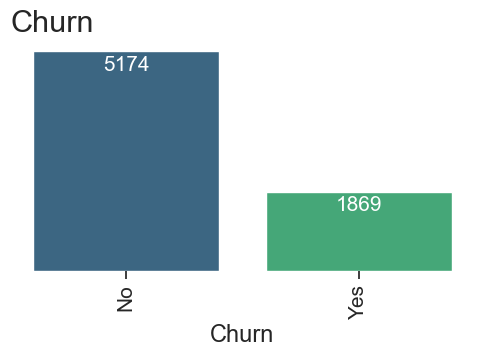

In [80]:
plot_countplot(dados, 'Churn', 'Churn', 'Churn')

Nota-se que a variável alvo, churn, está desbalanceada

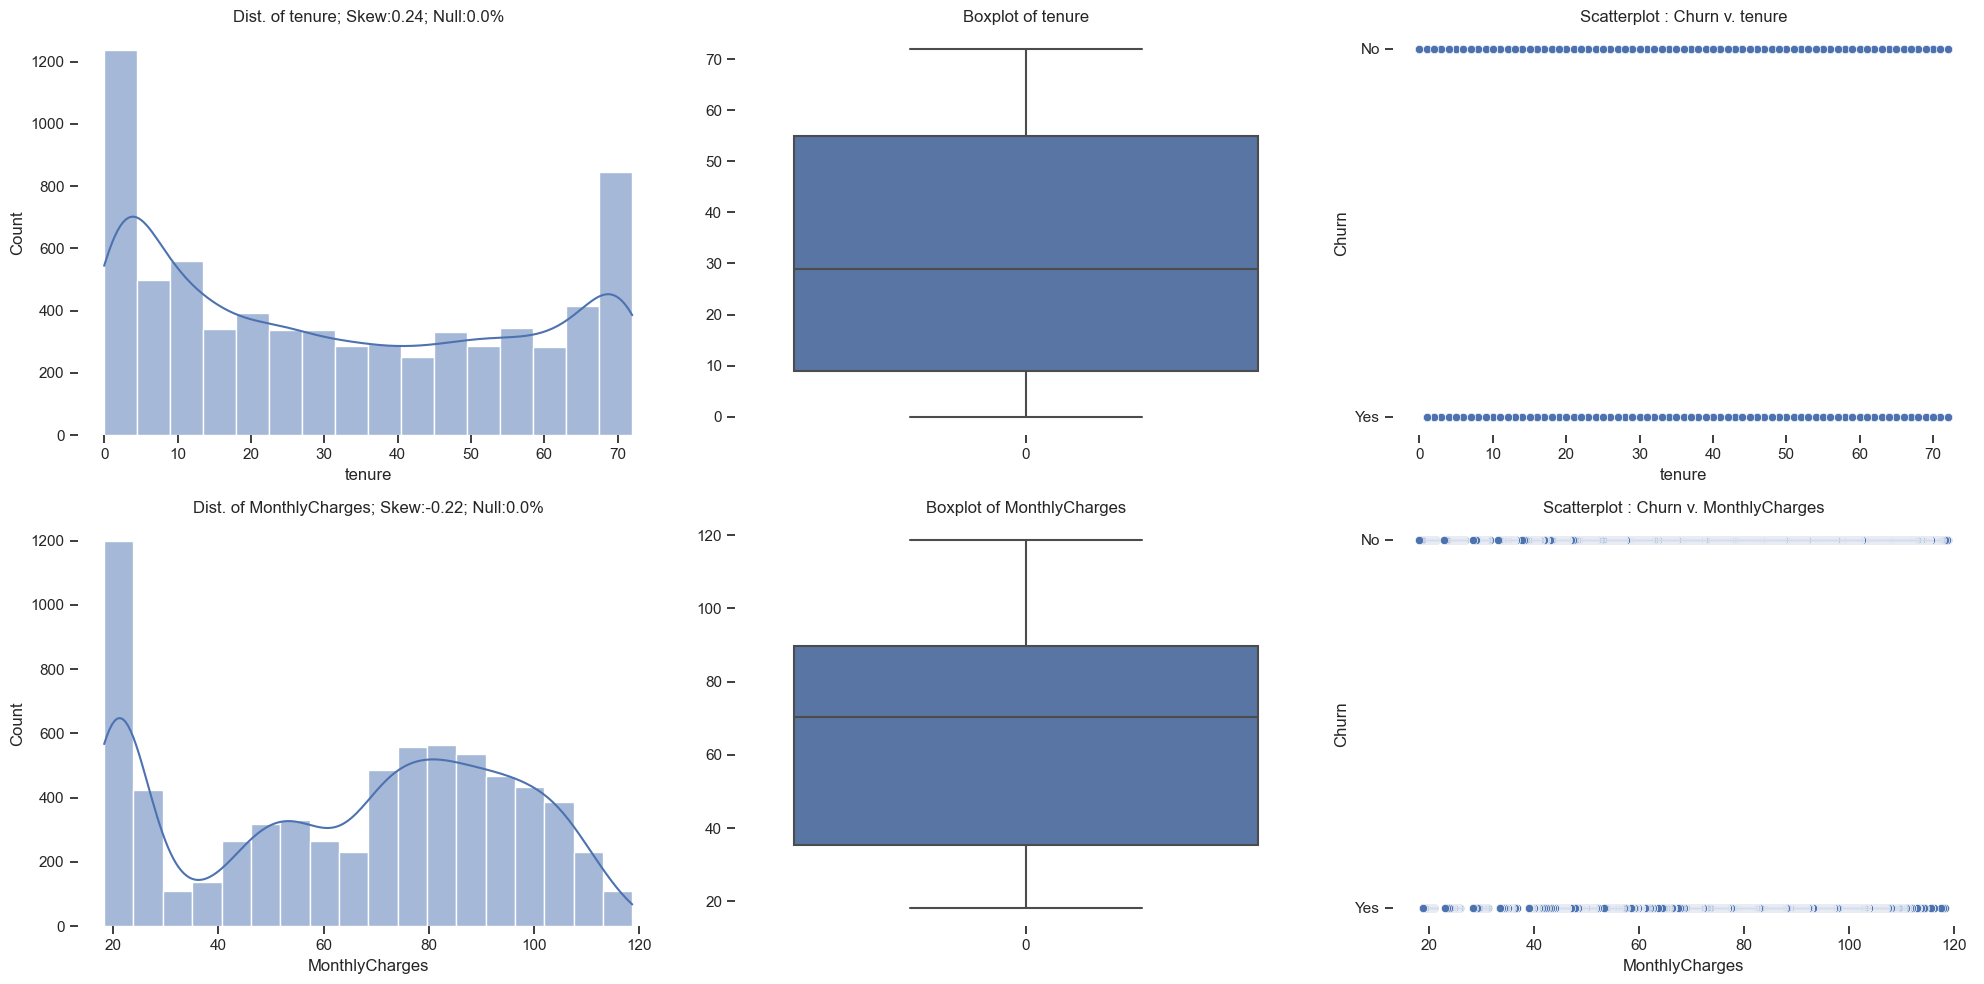

In [81]:
numerical_plot(dados)

#### Detalhe na variável tenure

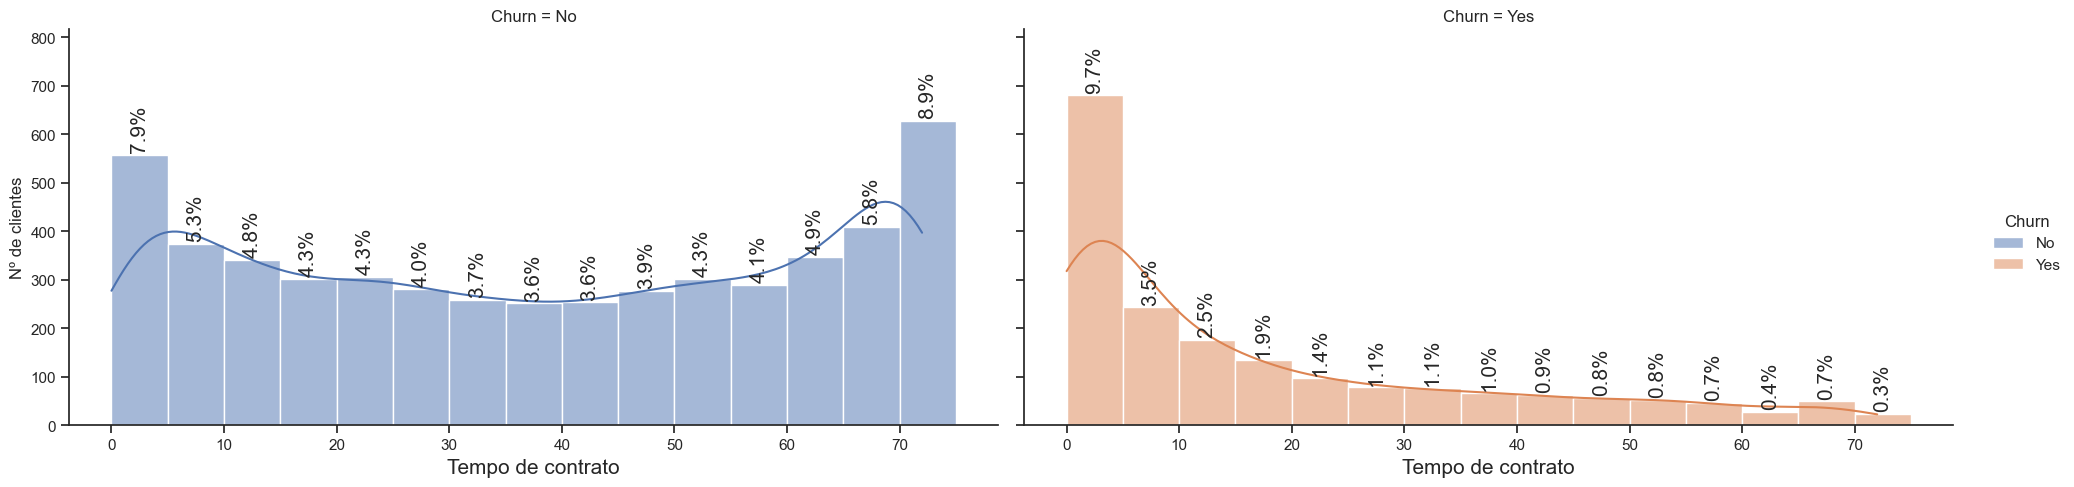

In [82]:
ax = sns.displot(data=dados, binwidth=5, x='tenure', col='Churn', hue='Churn', kde = True, aspect = 2)
ax.set_ylabels('Nº de clientes', fontsize = 12) # Mudando o título do eixo Y e aumentando o tamanho da fonte
ax.set_xlabels('Tempo de contrato', fontsize = 12) # Mudando o título do eixo X e aumentando o tamanho da fonte
total_registros = len(dados['Churn'])

for ax in ax.axes.ravel():
    
    # add annotations
    for c in ax.containers:

        # custom label calculates percent and add an empty string so 0 value bars don't have a number
        labels = [f'{w:0.1f}%' if (w := v.get_height()/total_registros*100) > 0 else '' for v in c]

        ax.bar_label(c, labels=labels, label_type='edge', fontsize=15, rotation=90, padding=2)
        ax.set_xlabel("Tempo de contrato", fontsize = 15) # Mudando o título do eixo X e aumentando o tamanho da fonte
    
    ax.margins(y=0.2)

plt.show()

Aqui não encontramos outliers. Temos um número maior de assinantes no primeiro mês, depois temos uma queda no número de assinantes e de valor nos primeiros meses, provavelmente devido ao alto churn nesses meses.

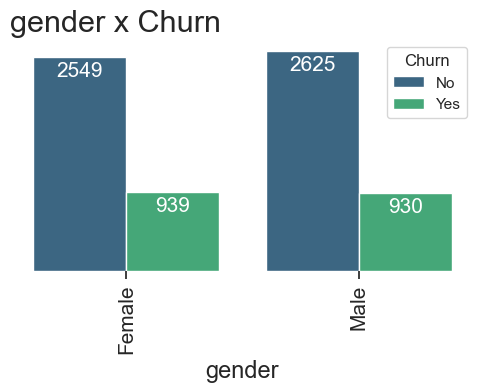

In [83]:
plot_countplot(dados=dados, x='gender', titulo='gender x Churn', label_x='gender', hue = 'Churn')

Não há diferença aparente entre gênero em relação ao churn

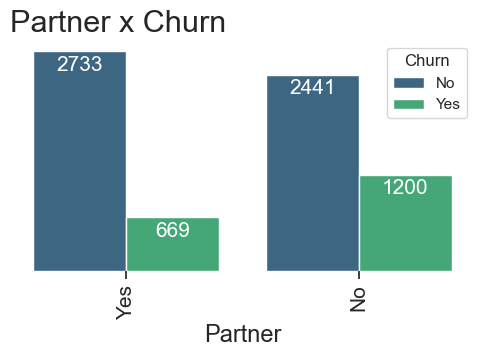

In [84]:
plot_countplot(dados=dados, x='Partner', titulo='Partner x Churn', label_x='Partner', hue = 'Churn')

Clientes com 0 na variável Partner, tem propensão ao churn

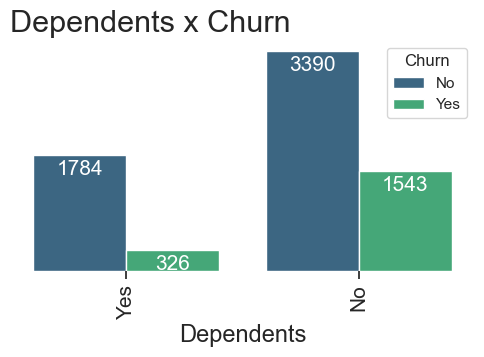

In [85]:
plot_countplot(dados=dados, x='Dependents', titulo='Dependents x Churn', label_x='Dependents', hue = 'Churn')

Clientes sem dependentes, tem propensão ao churn

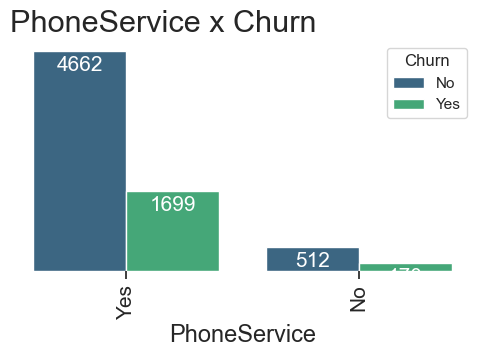

In [86]:
plot_countplot(dados=dados, x='PhoneService', titulo='PhoneService x Churn', label_x='PhoneService', hue = 'Churn')

Clientes com serviço telefônico tem maior representação e podem ser um indicativo de onde diminuir o churn

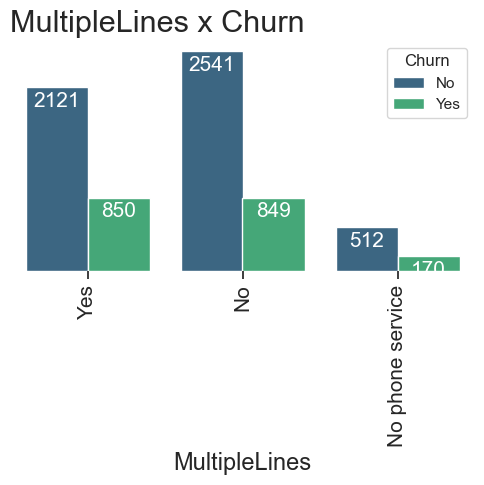

In [87]:
plot_countplot(dados=dados, x='MultipleLines', titulo='MultipleLines x Churn', label_x='MultipleLines', hue = 'Churn')

A proporção de clientes com e sem múltiplas linhas não tem muita diferença em relação ao churn

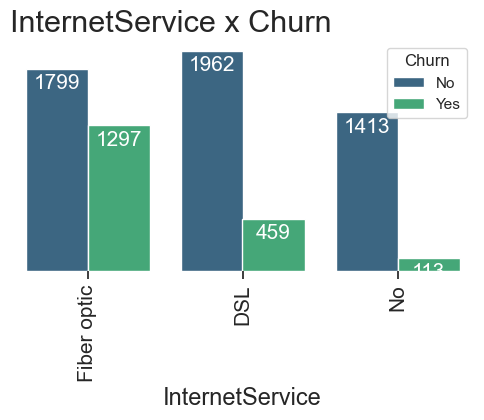

In [88]:
plot_countplot(dados=dados, x='InternetService', titulo='InternetService x Churn', label_x='InternetService', hue = 'Churn')

O serviço de fibra ótica apresenta proporcionalmente maior número de churn, outro ponto para analisar sobre o churn

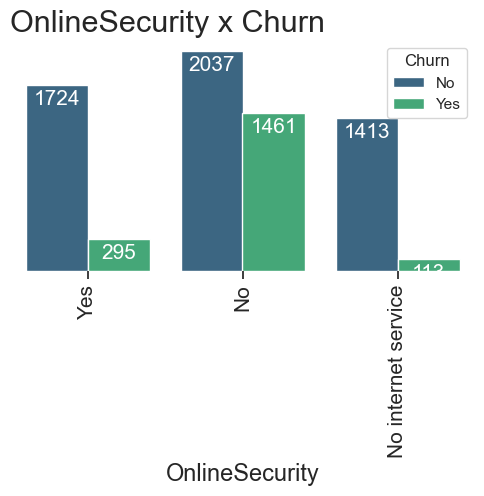

In [89]:
plot_countplot(dados=dados, x='OnlineSecurity', titulo='OnlineSecurity x Churn', label_x='OnlineSecurity', hue = 'Churn')

Clientes sem Online security, tem propensão ao churn

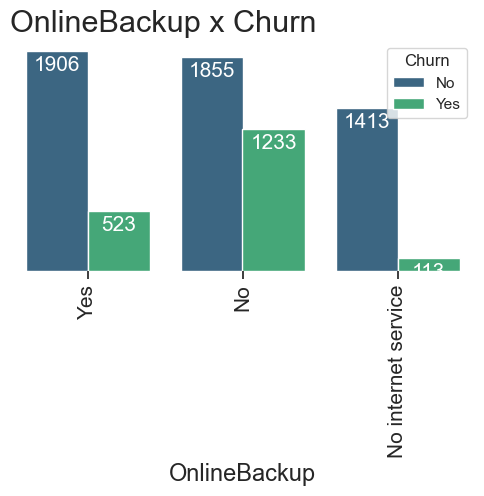

In [90]:
plot_countplot(dados=dados, x='OnlineBackup', titulo='OnlineBackup x Churn', label_x='OnlineBackup', hue = 'Churn')

Clientes sem Online backup, tem propensão ao churn

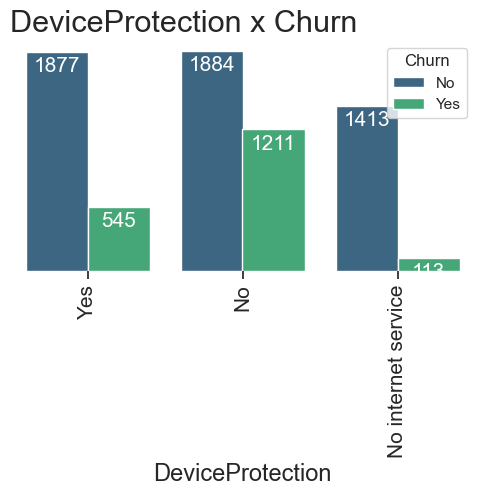

In [91]:
plot_countplot(dados=dados, x='DeviceProtection', titulo='DeviceProtection x Churn', label_x='DeviceProtection', hue = 'Churn')

Clientes sem device protection, tem propensão ao churn

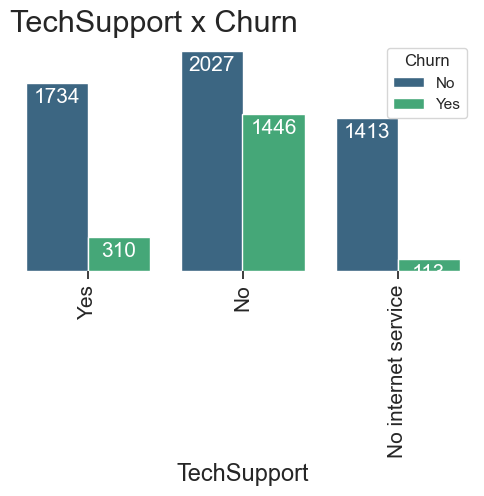

In [92]:
plot_countplot(dados=dados, x='TechSupport', titulo='TechSupport x Churn', label_x='TechSupport', hue = 'Churn')

Clientes sem tech support, tem propensão ao churn

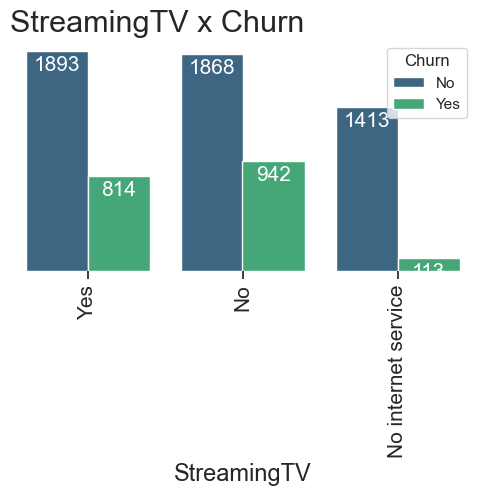

In [93]:
plot_countplot(dados=dados, x='StreamingTV', titulo='StreamingTV x Churn', label_x='StreamingTV', hue = 'Churn')

Aparentemente não há uma diferença grande entre o churn dos clientes com e sem streaming TV

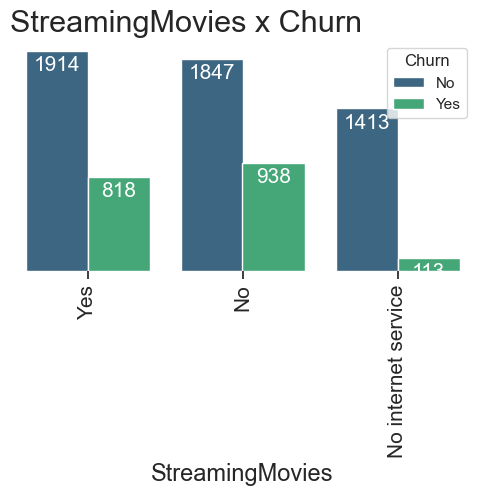

In [94]:
plot_countplot(dados=dados, x='StreamingMovies', titulo='StreamingMovies x Churn', label_x='StreamingMovies', hue = 'Churn')

O mesmo que streaming tv. Aparentemente não há uma diferença grande entre o churn

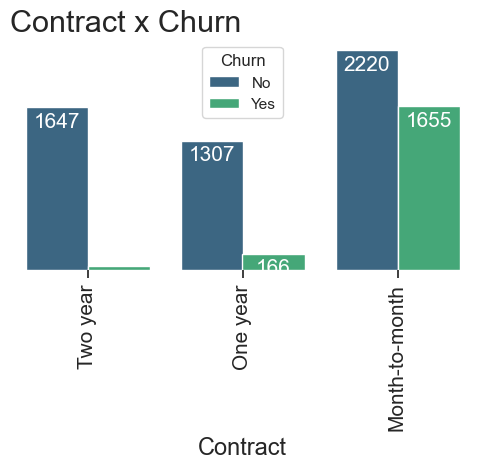

In [95]:
plot_countplot(dados=dados, x='Contract', titulo='Contract x Churn', label_x='Contract', hue = 'Churn')

Claramente os clientes com contratos mensais tem propensão a cancelar

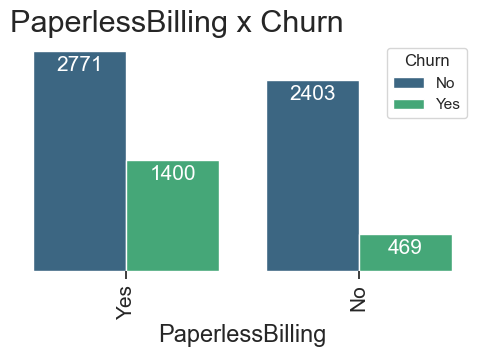

In [96]:
plot_countplot(dados=dados, x='PaperlessBilling', titulo='PaperlessBilling x Churn', label_x='PaperlessBilling', hue = 'Churn')

Clientes com paperlessbilling cancelam mais, talvez devido a facilidade do meio de pagamento

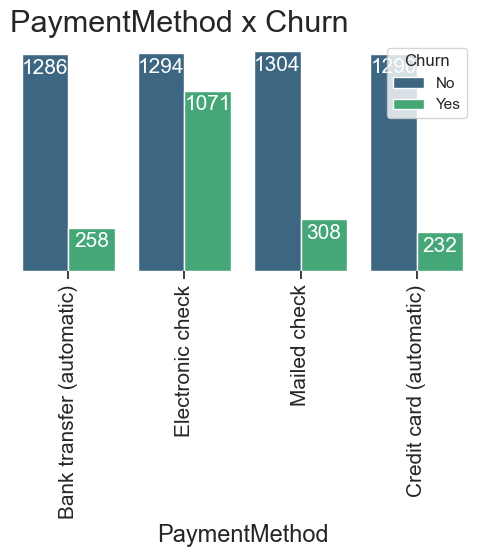

In [97]:
plot_countplot(dados=dados, x='PaymentMethod', titulo='PaymentMethod x Churn', label_x='PaymentMethod', hue = 'Churn')

Clientes com meio de pagamento eletronic check tem churn maior proporcionalmente aos outros

### Conclusões Iniciais

- O Genêro parece não ter muita relação com a Churn de clientes
- Pessoas acima de 65 anos, ou, sem parceiros, ou, sem dependentes tem uma tendência maior de Churn
- Ter serviço de telefone não parece ter muita relação com a Evasão de clientes
- Clientes com Serviço de internet de Fibra Optica tem uma tendência alta a evadir, o que pode indicar uma prestação desse serviço de baixa qualidade
- Clientes que não contrataram serviços como Onlinebackup, tech support ou Device protection tem mais chance de churn
- Clientes com contratos mensal tem uma tendência muito maior a evadir se comparado com os outros dois tipos de contrato. Isso pode ser explicado pelo fato de que clientes com pouco tempo de contrato tendem a evadir mais, porém quanto mais o tempo de contrato o cliente tem, menor essa chance fica
- A fatura online parece ter uma relação a evasao, provavelmente pelo fato de ser mais facil cancelar o contrato quando se tem a fatura online.
- Metódo de pagamento por Cheque eletrônico possui churn extremamente alta
- Clientes com menos tempo de contrato tem maior probabilidade de churn, 50 % dos clientes o fizeram nos primeiros 10 meses.
- O total gasto é maior para clientes que permanecem, isso se deve pelo fato de que clientes que permanecem irão naturalmente possuir um gasto total maior

### Correlações

C:\Users\arsnf\AppData\Local\Temp\ipykernel_27604\4267116575.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


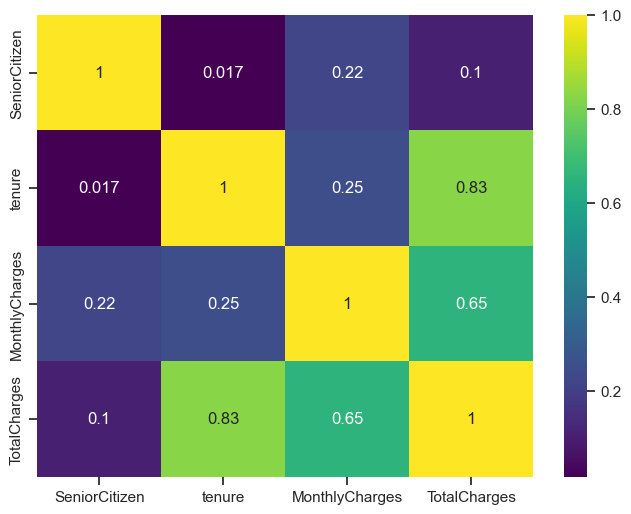

In [98]:
def heatmap_corr(df, figsize: tuple = (8, 6)):
    corr = df.corr()
    plt.figure(figsize=figsize)
    sns.heatmap(corr,
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values,
                annot=True,
                cmap='viridis')
    
heatmap_corr(dados)

As features "tenure" e "TotalCharges" possuem uma correlação forte, o que significa que a medida que uma aumenta a outra aumenta também. Não é muito interessante trabalharmos com duas features correlacionadas, portanto pode-se pensar em remover a feature "TotalCharges"

## Premissas geradas pela análise

- Clientes com Serviço de internet de Fibra Optica tem uma tendência alta ao churn, o que pode indicar uma prestação desse serviço de baixa qualidade
- Clientes com contratos mensal tem uma tendência muito maior ao churn se comparado com os outros dois tipos de contrato. Isso pode ser explicado pelo fato de que clientes com pouco tempo de contrato tendem a evadir mais, porém quanto mais o tempo de contrato o cliente tem, menor essa chance
- Clientes sem techsupport, deviceprotection e olinesuporte cancelam mais proporcionalmente
- A fatura online parece ter uma relação a evasao, provavelmente pelo fato de ser mais facil cancelar o contrato quando se tem a fatura online.
- Metódo de pagamento por Cheque eletrônico possui uma evasão extremamente alta

Uma primeira recomendação de negócio seria investigar o serviço de fibra óptica e os clientes com pagamento via cheque eletrônico. Também podemos conferir se nos primeiros meses são ofertados mais serviços para os assinantes ou upgrades para planos anuais.

Outra proposta seria implementar modelos de previsão do churn e classificação dos assinantes para antecipação do cancelamento. Serão feitos a seguir modelos com o propósito de demonstrar esse argumento.

## Protótipo de machine learning para previsão de churn

É necessário transformar os dados categóricos em numéricos para interpretação dos modelos. Substituiremos os valores de Yes e No por 0 e 1. Assim como, o valor de No internet service como 0 para simplificação. As variáveis com mais categorias serão transformadas via label encoder.

In [99]:
dicionario = {'No internet service':0,
              'No phone service': 0,
              'No': 0,
              'Yes': 1,
              'Male':0,
              'Female':1}

colunas = [ 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'PaperlessBilling',
       'MonthlyCharges', 'TotalCharges', 'Churn']

dados_dic = dados[colunas].replace(dicionario)
dados_dic.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn
0,1,0,1,1,72,1,1,1,1,1,1,1,1,1,118.75,8672.45,0
1,1,0,0,0,71,1,1,1,1,1,1,1,1,1,118.65,8477.60,0
2,1,0,1,0,68,1,1,1,1,1,1,1,1,0,118.60,7990.05,0
3,1,0,0,0,61,1,1,1,1,1,1,1,1,1,118.60,7365.70,0
4,0,0,0,0,67,1,1,1,1,1,1,1,1,1,118.35,7804.15,1


In [100]:
colunas_muitas_cat = ['PaymentMethod', 'Contract', 'InternetService']
dados_muitas_cat = dados[colunas_muitas_cat]

le = LabelEncoder()                                            
le.fit(dados_muitas_cat['PaymentMethod'])
dados_muitas_cat['PaymentMethod'] = le.transform(dados_muitas_cat['PaymentMethod'])    

le.fit(dados_muitas_cat['Contract'])
dados_muitas_cat['Contract'] = le.transform(dados_muitas_cat['Contract']) 

le.fit(dados_muitas_cat['InternetService'])
dados_muitas_cat['InternetService'] = le.transform(dados_muitas_cat['InternetService']) 

dados_ml = pd.concat([dados_dic, dados_muitas_cat], axis=1)
dados_ml.head()

C:\Users\arsnf\AppData\Local\Temp\ipykernel_27604\332067059.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_muitas_cat['PaymentMethod'] = le.transform(dados_muitas_cat['PaymentMethod'])
C:\Users\arsnf\AppData\Local\Temp\ipykernel_27604\332067059.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_muitas_cat['Contract'] = le.transform(dados_muitas_cat['Contract'])
C:\Users\arsnf\AppData\Local\Temp\ipykernel_27604\332067059.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy 

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,PaymentMethod,Contract,InternetService
0,1,0,1,1,72,1,1,1,1,1,1,1,1,1,118.75,8672.45,0,0,2,1
1,1,0,0,0,71,1,1,1,1,1,1,1,1,1,118.65,8477.60,0,2,2,1
2,1,0,1,0,68,1,1,1,1,1,1,1,1,0,118.60,7990.05,0,3,2,1
3,1,0,0,0,61,1,1,1,1,1,1,1,1,1,118.60,7365.70,0,2,1,1
4,0,0,0,0,67,1,1,1,1,1,1,1,1,1,118.35,7804.15,1,0,1,1


#### Dividindo os dados em treino e teste para aplicação inicial dos modelos testados

In [101]:
X = dados_ml.drop(['Churn'], axis = 1)
y = dados_ml['Churn']
SEED = 237

X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=SEED)

Será usado um validador cruzado estratificado K-Fold. Ele fornece índices de treinamento/teste para dividir dados em conjuntos de treinamento/teste. Este objeto de validação cruzada é uma variação do KFold que retorna folds estratificadas. As folds são feitas preservando a porcentagem de amostras de cada classe. O treino será feito em alguns modelos para teste e escolheremos o de melhor desempenho.

In [102]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=101)
scaler = MinMaxScaler()

# Calcular a proporção de exemplos da classe negativa para a classe positiva
positives = sum(y)
negatives = len(y) - positives
scale_pos_weight = negatives / positives

# Função para rodar os modelos
def run_modelo(modelo, X, y, cv):
    X = scaler.fit_transform(X)
    cv_results = cross_validate(modelo, X, y, cv=cv, n_jobs=-1, scoring=['precision', 'recall', 'accuracy'])
    acuracia_media = round(cv_results['test_accuracy'].mean(), 3)
    precisao_media =  round(cv_results['test_precision'].mean(), 3)
    recall_medio = round(cv_results['test_recall'].mean(), 3)
    return [acuracia_media, precisao_media, recall_medio]

rfc = RandomForestClassifier(random_state=SEED, n_jobs=-1, class_weight='balanced')
gbc = GradientBoostingClassifier(random_state=SEED)
gnb = GaussianNB()
knn = KNeighborsClassifier(n_jobs=-1)

modelos = [rfc, gbc, gnb, knn]
nome_modelos = ['RandomForest', 'XGBoost', 'NaiveBayes', 'KNN']
resultados = []

for i, modelo in enumerate(modelos):
    resultados.append(run_modelo(modelo, X_treino, y_treino, skf))

resultados = pd.DataFrame(resultados, index=nome_modelos, columns=['Acurácia', 'Precisão', 'Recall'])
resultados.sort_values('Acurácia', ascending = False)

,Acurácia,Precisão,Recall
XGBoost,0.800,0.658,0.510
RandomForest,0.786,0.631,0.461
NaiveBayes,0.753,0.525,0.715
KNN,0.748,0.528,0.480


In [103]:
#gbclass = GradientBoostingClassifier(random_state=SEED)
gbc = gbc.fit(X_treino, y_treino)
predito_gbc = gbc.predict(X_teste)

print(classification_report(y_teste, predito_gbc))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1033
           1       0.66      0.55      0.60       376

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.80      0.80      0.80      1409



Nesse primeiro momento, usaremos o XGboost pela melhor performance inicial. Deve-se aprimorar esse modelo para melhores resultados, inclusive dando mais atenção ao desbalanceamento das classes.

In [104]:
X1 = scaler.transform(dados_ml.drop(['Churn'], axis = 1))
propensao = gbc.predict_proba(X1)
propensao

C:\Users\arsnf\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


array([[0.27194528, 0.72805472],
       [0.20843972, 0.79156028],
       [0.46434329, 0.53565671],
       ...,
       [0.87886362, 0.12113638],
       [0.94762167, 0.05237833],
       [0.71225314, 0.28774686]])

## Protótipo da classificação dos assinantes

Como validação da proposta, será feita uma classificação baseada na

Nesse protótipo, será usado o modelo mais utilizado, o K-means. O K-means costuma ser mais aplicado em dados com poucas dimensões de dados numéricos e continuos para organizar os dados em grupos categóricos. O K-Means tem o objetivo de dividir as observações em k clusters baseado nas menores distâncias euclidianas. Aplicaremos k=4 para o número de clusters da classificação na análise inicial.

In [105]:
#calcula a receita para cada cliente
dados_receita = dados.groupby('customerID').sum().reset_index()[['customerID', 'tenure', 'TotalCharges']]
dados_receita.head()

C:\Users\arsnf\AppData\Local\Temp\ipykernel_27604\10041852.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dados_receita = dados.groupby('customerID').sum().reset_index()[['customerID', 'tenure', 'TotalCharges']]


,customerID,tenure,TotalCharges
0,0002-ORFBO,9,593.30
1,0003-MKNFE,9,542.40
2,0004-TLHLJ,4,280.85
3,0011-IGKFF,13,1237.85
4,0013-EXCHZ,3,267.40


In [106]:
# rodando o kmeans para nossa quantidade ótima de clusters
df_pagamento = dados_receita[['TotalCharges']]
kmeans_receita = KMeans(n_clusters=4)
dados_receita['receita_cluster'] = kmeans_receita.fit_predict(df_pagamento)
dados_receita.groupby('receita_cluster')['TotalCharges'].describe()

C:\Users\arsnf\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,count,mean,std,min,25%,50%,75%,max
receita_cluster,,,,,,,,
0,3131.0,409.001230,336.351225,18.80,93.3500,318.900,675.0750,1139.20
1,1224.0,4119.728431,684.926091,2997.45,3521.4625,4100.475,4729.9625,5377.80
2,1706.0,1881.487984,527.381623,1140.05,1415.6250,1782.400,2303.1000,2995.45
3,982.0,6643.253921,851.169893,5386.50,5917.1000,6519.050,7290.9125,8684.80


Os clusters devem ser reorganizados de modo que o cluster 3 fique com os clientes com maior receita gerada, facilitando a compreensão.

In [107]:
#função para ordenar o número de clusters 
def ordenar_cluster(cluster_nome, target_nome,df,ascending):
    novo_nome = 'novo' + cluster_nome
    agrupado_por_cluster = df.groupby(cluster_nome)[target_nome].mean().reset_index()
    agrupado_por_cluster_ordenado = agrupado_por_cluster.sort_values(by=target_nome,
                                                                     ascending=ascending).reset_index(drop=True)
    agrupado_por_cluster_ordenado['index'] = agrupado_por_cluster_ordenado.index
    juntando_cluster = pd.merge(df,agrupado_por_cluster_ordenado[[cluster_nome,'index']], on=cluster_nome)
    removendo_dados = juntando_cluster.drop([cluster_nome],axis=1)
    df_final = removendo_dados.rename(columns={"index":cluster_nome})
    return df_final

dados_receita = ordenar_cluster('receita_cluster', 'TotalCharges',dados_receita,False)
dados_receita.groupby('receita_cluster')['TotalCharges'].describe()

,count,mean,std,min,25%,50%,75%,max
receita_cluster,,,,,,,,
0,982.0,6643.253921,851.169893,5386.50,5917.1000,6519.050,7290.9125,8684.80
1,1224.0,4119.728431,684.926091,2997.45,3521.4625,4100.475,4729.9625,5377.80
2,1706.0,1881.487984,527.381623,1140.05,1415.6250,1782.400,2303.1000,2995.45
3,3131.0,409.001230,336.351225,18.80,93.3500,318.900,675.0750,1139.20


Agora, os dados dos modelos são unidos na nossa base para uma primeira visão geral

In [108]:
dados_prev = pd.merge(dados, dados_receita[['customerID','receita_cluster']], on ='customerID', how = 'inner')
dados_prev['prop_churn'] = propensao[::, 1]
dados_prev[['tenure', 'TotalCharges', 'prop_churn', 'receita_cluster', ]].sort_values('prop_churn', ascending = True)

,tenure,TotalCharges,prop_churn,receita_cluster
5755,69,1718.20,0.036026,2
5544,71,1847.55,0.036026,2
5545,70,1715.15,0.036026,2
5549,0,25.35,0.036026,3
5563,63,1573.05,0.036026,2
...,...,...,...,...
5139,12,526.95,0.986124,3
4745,33,1750.85,0.989331,2
4464,33,1803.70,0.989570,2
4141,46,2816.65,0.989712,2


Text(0, 0.5, 'Probabilidade de churn')

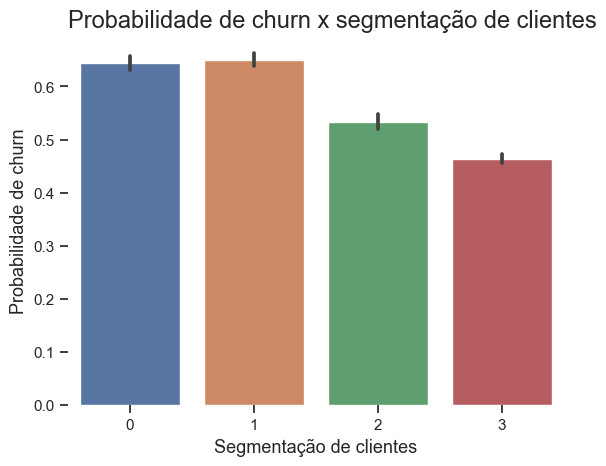

In [112]:
sns.barplot(x='receita_cluster', y = 'prop_churn', data=dados_prev)
plt.title('Probabilidade de churn x segmentação de clientes', fontsize=17, loc='left')
plt.xlabel('Segmentação de clientes', fontsize=13)
plt.ylabel('Probabilidade de churn', fontsize=13)
#plt.xticks(fontsize=15, rotation='vertical')

Nota-se a alta taxa de churn em todos os clusteres. No entanto, nossa proposta se mostra válida, onde a propensão ao churn diminui conforme o cluster. 

## Conclusões e propostas

Após a análise realizada podemos confirmar as sugestões feitas:

- Implementar upgrade dos planos mensais para os anuais
- Oferecer descontos aos assinantes para incluirem techsupport, deviceprotection, online backup ou onlinesecurity. Poderia ser ofertado ao incluir deviceprotection, o assinante ganha o streaming incluso, por exemplo
- Oferecer programa de recompensas ou pontos, principalmente nos primeiros meses para evitar o churn.
- Otimizar protótipos de modelos de previsão e classificação. Segmentando os assinantes por receita, propensão ao churn e outras variáveis pode nos levar a novas regras de negócio que vão diminuir o churn